# Predicting Manufacturing Failures using Classification
_By Max Santos_

This notebook looks at data from a manufacturing company who create widgets. During the manufacturing process, almost 600 sensors provide measurements/readings for each widget that is made. Unfortunately, a very large proportion of widgets 'fail' in the manufacturing process and cannot be used. 

Therefore, the aim of this analysis is to build a predictive model that can use data from the sensors to predict whether a widget will results in **failure or success**. This would have huge benefit to the manufacturing company in reducing the number of failures, and also identifying which sensors are most useful for doing so. 

## Importing Data & Cleaning

First I will import and clean the data. The sensor readings are contained in 'measurements.data' and the failure/success label for each widget is contained in 'labels.data'. 

In [43]:
import pandas as pd
import numpy as np
from IPython.display import display
import pylab
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
# Read in the data and inspect the layout, columns, variables etc

measurements = pd.read_csv('measurements.data', sep=" ", header=None)
labels = pd.read_csv('labels.data', sep=" ", header=None)

In [45]:
measurements.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [46]:
labels.head()

,0,1
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,-1,19/07/2008 14:43:00
4,-1,19/07/2008 15:22:00


In [47]:
# rename columns
labels.rename(columns={0: 'Target', 1:'Timestamp'}, inplace=True)

# convert Target 'failure' to 0s
labels.loc[labels['Target'] == -1, 'Target'] = 0

labels.head()

,Target,Timestamp
0,0,19/07/2008 11:55:00
1,0,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,0,19/07/2008 14:43:00
4,0,19/07/2008 15:22:00


In [48]:
# merge tables together

data = pd.merge(measurements, labels, left_index=True, right_index=True)

In [49]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,582,583,584,585,586,587,588,589,Target,Timestamp
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0,19/07/2008 11:55:00
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0,19/07/2008 12:32:00
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1,19/07/2008 13:17:00
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0,19/07/2008 14:43:00
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0,19/07/2008 15:22:00


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, 0 to Timestamp
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


In [51]:
# Inspect how much missing data there is

total = data.isnull().sum().sort_values(ascending=False)
percent = (100*data.isnull().sum()/data.shape[0]).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percentage Missing'])
missing_data.head(20)

,Total Missing,Percentage Missing
293,1429,91.193363
292,1429,91.193363
157,1429,91.193363
158,1429,91.193363
85,1341,85.577537
220,1341,85.577537
358,1341,85.577537
492,1341,85.577537
382,1018,64.964901
383,1018,64.964901


In [52]:
# remove any rows or columns that are missing all values

data.dropna(how ='all') 
data.dropna(axis=1, how='all')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, 0 to Timestamp
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


### Missing Data

As there is little info on the features and their significance, we will assume that the data is missing completely at random (MCAR). It would also be worth considering running statistical tests to determine whether this is true (if it is MCAR or MAR). To preserve simplicity, we will remove features with 45% or more missing values.

In [53]:
# select features that have >45% missing data

features_to_remove = missing_data.loc[missing_data['Percentage Missing'] >= 45]

features_to_remove

,Total Missing,Percentage Missing
293,1429,91.193363
292,1429,91.193363
157,1429,91.193363
158,1429,91.193363
85,1341,85.577537
220,1341,85.577537
358,1341,85.577537
492,1341,85.577537
382,1018,64.964901
383,1018,64.964901


In [54]:
cols_to_remove = list(features_to_remove.index.values)

cols_to_remove

[293,
 292,
 157,
 158,
 85,
 220,
 358,
 492,
 382,
 383,
 518,
 517,
 516,
 110,
 109,
 244,
 111,
 245,
 246,
 384,
 579,
 580,
 581,
 578,
 72,
 73,
 345,
 346,
 385,
 112,
 247,
 519]

In [55]:
# drop unwanted columns from dataset

data_cleaned = data.drop(data.columns[cols_to_remove],axis=1)

data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 560 entries, 0 to Timestamp
dtypes: float64(558), int64(1), object(1)
memory usage: 6.7+ MB


### Imputation

We will now impute any missing values from the remaining columns. We will assume that all of the sensors are taking continuous (not discrete) measurements as float values, and will therefore impute missing values using the median (to avoid bias from skewed features). Multiple imputation (e.g. MICE) could also be used here.

In [56]:
data_imputed = data_cleaned.fillna(data_cleaned.median())

Columns with only 1 unique value will also be removed, as they add no information to the model. This leaves 444 remaining columns (down from 560).

In [57]:
#remove columns with only 1 unique value
for col in data_imputed.columns:
    if len(data_imputed[col].unique()) == 1:
        data_imputed.drop(col,inplace=True,axis=1)
        
data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 444 entries, 0 to Timestamp
dtypes: float64(442), int64(1), object(1)
memory usage: 5.3+ MB


In [58]:
# convert timestamp column to datetime format for exploratory analysis

data_imputed['Timestamp'] =  pd.to_datetime(data_imputed['Timestamp'], format='%d/%m/%Y %H:%M:%S')

## Exploratory Data Analysis

### Time-series Analysis

First I will inspect whether the percentage of 'successes' fluctuates over time, or follows a trend.

In [59]:
trend_analysis = data_imputed[['Target','Timestamp']].copy()
trend_analysis['Timestamp'] = trend_analysis['Timestamp'].values.astype('<M8[D]')
trend_analysis.set_index(['Timestamp'], inplace=True)
trend_analysis.head()

,Target
Timestamp,
2008-07-19,0
2008-07-19,0
2008-07-19,1
2008-07-19,0
2008-07-19,0


In [60]:
t1 = pd.DataFrame(data = trend_analysis.groupby(level=[0]).count())

t1.rename(columns={'Target':'Total Instances'}, inplace=True)

t1.head()

,Total Instances
Timestamp,
2008-07-19,12
2008-07-20,1
2008-07-21,2
2008-07-22,6
2008-07-23,2


In [61]:
t2 = pd.DataFrame(data = trend_analysis.groupby(level=[0]).sum())

t2.rename(columns={'Target':'Total Successes'}, inplace=True)

t2.head()

,Total Successes
Timestamp,
2008-07-19,3
2008-07-20,0
2008-07-21,1
2008-07-22,0
2008-07-23,0


In [62]:
trend_analysis_grouped = pd.merge(left=t1, right=t2, left_index=True, right_index=True)

trend_analysis_grouped['Percentage Of Success'] = ((trend_analysis_grouped['Total Successes'])/(trend_analysis_grouped['Total Instances']))*100

trend_analysis_grouped.head(10)

,Total Instances,Total Successes,Percentage Of Success
Timestamp,,,
2008-07-19,12,3,25.000000
2008-07-20,1,0,0.000000
2008-07-21,2,1,50.000000
2008-07-22,6,0,0.000000
2008-07-23,2,0,0.000000
2008-07-25,1,1,100.000000
2008-07-27,10,0,0.000000
2008-07-28,8,2,25.000000
2008-07-29,12,4,33.333333


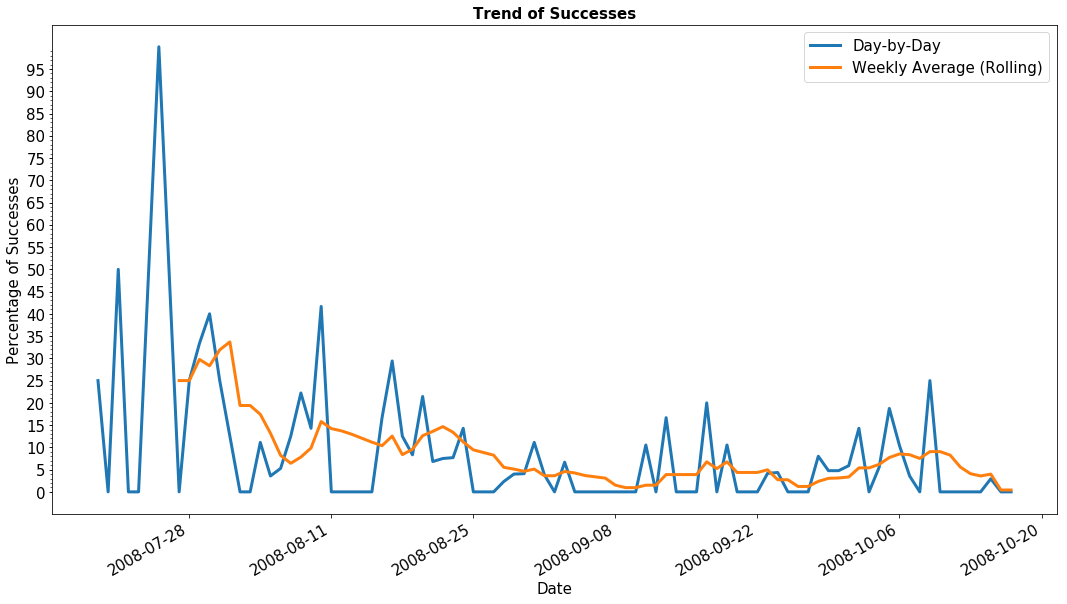

In [63]:
ax = trend_analysis_grouped['Percentage Of Success'].plot(figsize=(18, 10),fontsize=15, linewidth=3,label='Day-by-Day')

plt.title('Trend of Successes', fontweight='bold', fontsize=15)

major_ticks = np.arange(0, 100, 5)
minor_ticks = np.arange(0, 100, 1)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

success_perc_mean = trend_analysis_grouped['Percentage Of Success'].rolling(window=7).mean()
ax = success_perc_mean.plot(linewidth=3, label='Weekly Average (Rolling)')

ax.set_ylabel('Percentage of Successes',fontsize=15)
ax.set_xlabel('Date',fontsize=15)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,loc=1, prop={'size': 15})

plt.show()

The plot above shows a very gradual downward trend in the average percentage of successes (with a large spike in July). There are clear peaks at what appear to be regular intervals. Otherwise, there isn't a particularly clear pattern, however, a larger time-range of data would make this much easier to determine.

### Correlation between numerical values

This (very messy!) heatmap shows the pearson correlation coefficients (or bivariate correlation) for the most correlated variables in the dataset (with an absolute correlation greater than 0.99). There are several pairs of variables that have this extremely high correlation (multicollinearity).

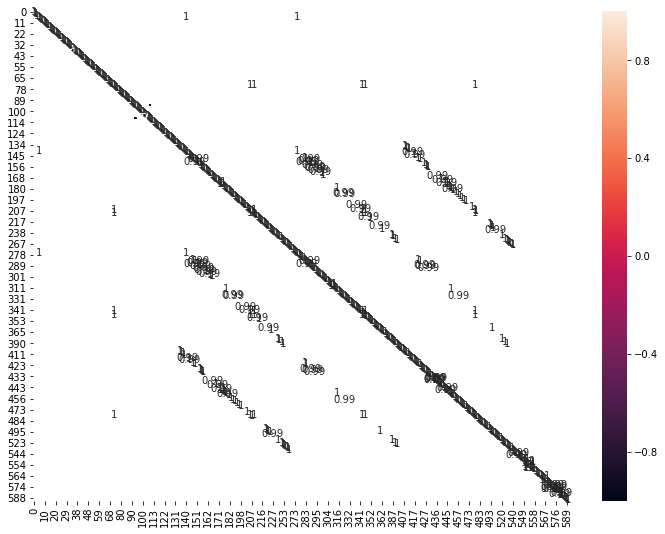

In [64]:
correlation = data_imputed.corr()
fig, ax = plt.subplots(figsize=(12, 9))
display(sns.heatmap(correlation[(correlation >= 0.99) | (correlation <= -0.99)],annot=True))

### Checking for class imbalance

In [65]:
# event rate of success

PercSuccess = data_imputed['Target'].value_counts(normalize=True)*100
print("\n","Percentage of Failure/Success")
display(PercSuccess)


 Percentage of Failure/Success


0    93.363114
1     6.636886
Name: Target, dtype: float64

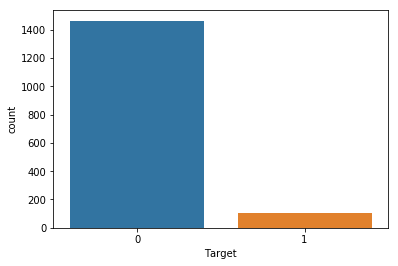

In [66]:
sns.countplot(x='Target', data=data_imputed)

This shows that we have some class imbalance, which will affect our modelling, and which metrics we use to measure it's performance. In fact, we have only 6.6% event rate in our target column.

This can be solved by certain resampling techniques, such as random undersampling, random oversampling or SMOTE). These techniques can all overcome the issue of imbalance, but can also cause overfitting. 

Another solution to imbalanced datasets, is the use of ensemble modelling techniques (either bagging or boosting). 

In this case, I will attempt to use a combination of resampling and ensemble modelling.

### Re-sampling: Oversampling with SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) involves the creation of 'synthetic' data points, in order to increase the number of the minority class, until the point that the two classes are balanced. I will first split the data in to training and test sets, and then perform SMOTE on the training set. 

#### Setting up training and test data

In [67]:
from sklearn.model_selection import train_test_split

# Create feature and target arrays
X = data_imputed.drop(['Timestamp','Target'], axis=1)
y = data['Target']

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=11)

#### Performing SMOTE on the training data

In [68]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=11, ratio = 'auto')
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

In [69]:
print("Percentage of positive samples in training set before re-sampling","\n",(y_train.sum())/(y_train.count())*100)

print("Percentage of positive samples in training set after re-sampling","\n",(y_train_sm.sum())/len(y_train_sm)*100)

Percentage of positive samples in training set before re-sampling 
 6.569343065693431
Percentage of positive samples in training set after re-sampling 
 50.0


## Predictive Modelling

**Feature Selection**

We currently have 442 features, which is a large number. I will try reducing this using PCA later on in the analysis.
As seen below, our number of data points in the training set has now increased (due to SMOTE creating synthetic observations).

In [70]:
print(X_train.shape)
print(X_train_sm.shape)

(1096, 442)
(2048, 442)


**Model Selection**

As mentioned before, I will use ensemble methods for my model, as they are particularly good at dealing with imbalanced datasets and avoiding overfitting. Specifically, I will use Random Forest (a bagging technique) and AdaBoost (a boosting technique). I will also fit a standard Decision Tree for comparison.

I will use the area under the curve (AUC) of the ROC graph as my metric for performance. Accuracy can be misleading in such cases, and the AUC is much more meaningful as it relates to the Precision and Recall.

For Random Forest and AdaBoost, I will also perform some parameter tuning in an effort to improve performance.

In [71]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, f1_score

# create dictionaries to store performance metrics for comparison
accuracy_comparison = {}
f1_comparison = {}
auc_comparison = {}

def fit_model(algorithm, X_train, y_train, X_test, y_test, title):

    # running k=10 folds cross-validation
    scores = cross_val_score(algorithm, X_train, y_train, cv=10, scoring='accuracy') 
    print('{0} CV Scores on Training Data:'.format(title),scores)
    print('\n','Mean of Accuracy on Training Data:',scores.mean())

    #fitting model and predicting
    model = algorithm

    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    print('\n','Accuracy Score on Test Data:',accuracy_score(y_test, predictions))
    print('\n','{0} Classification Report:'.format(title),'\n',classification_report(y_test, predictions))
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{0} ROC Curve'.format(title))
    plt.show()

    # Compute and print Area Under Curve: AUC score
    print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
    
    # save performance metrics for later comparison
    accuracy_comparison[title] = (accuracy_score(y_test, predictions)*100).round(1)
    f1_comparison[title] = (f1_score(y_test, predictions,average='weighted')*100).round(1)
    auc_comparison[title] = (roc_auc_score(y_test, y_pred_prob)).round(2)

### First Model: Decision Tree

Decision Tree CV Scores on Training Data: [0.84951456 0.89320388 0.93203883 0.93203883 0.91666667 0.93137255
 0.91666667 0.92156863 0.92156863 0.92647059]

 Mean of Accuracy on Training Data: 0.914110984199505

 Accuracy Score on Test Data: 0.8535031847133758

 Decision Tree Classification Report: 
              precision    recall  f1-score   support

          0       0.94      0.90      0.92       439
          1       0.11      0.16      0.13        32

avg / total       0.88      0.85      0.87       471



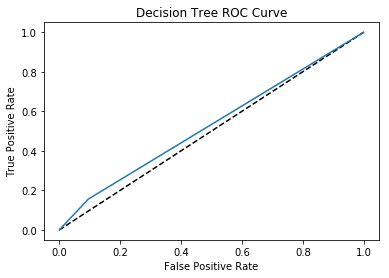

AUC: 0.5302890091116172


In [72]:
from sklearn.tree import DecisionTreeClassifier

fit_model(DecisionTreeClassifier(random_state=12), X_train_sm, y_train_sm, X_test, y_test, 'Decision Tree')

### Second Model: Random Forest

Random Forest CV Scores on Training Data: [0.94174757 0.99029126 0.97087379 0.98058252 0.99019608 0.96568627
 0.98039216 0.99019608 0.9754902  0.99019608]

 Mean of Accuracy on Training Data: 0.9775652008376167

 Accuracy Score on Test Data: 0.9278131634819533

 Random Forest Classification Report: 
              precision    recall  f1-score   support

          0       0.94      0.99      0.96       439
          1       0.33      0.06      0.11        32

avg / total       0.89      0.93      0.90       471



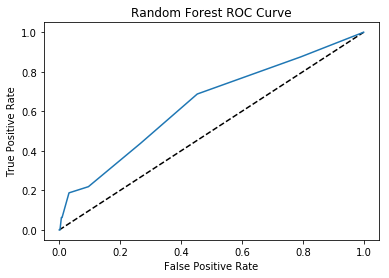

AUC: 0.6367098519362188


In [73]:
from sklearn.ensemble import RandomForestClassifier

fit_model(RandomForestClassifier(random_state=12), X_train_sm, y_train_sm, X_test, y_test, 'Random Forest')

#### Parameter Tuning for Random Forest

I will now perform some tuning of the random forest parameters to see if there is any increase in performance. 

Tuned Random Forest Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 50} 


 Random Forest Classification Report: 
              precision    recall  f1-score   support

          0       0.93      1.00      0.97       439
          1       1.00      0.03      0.06        32

avg / total       0.94      0.93      0.90       471



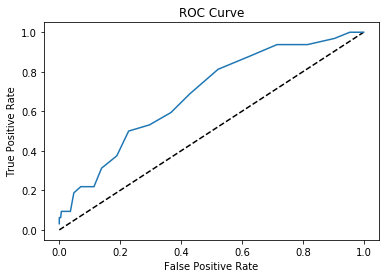

AUC: 0.6870373006833713


In [74]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# parameter tuning
#create random forest classifier
forest = RandomForestClassifier(random_state=12)

# Choose some parameter combinations to try
parameters = {'n_estimators': [5, 10, 25, 50], 
              'max_features': ['log2', 'sqrt'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [None, 5, 10], 
             }

# Run the grid search with 10-fold cross-validation
grid = GridSearchCV(forest, parameters,scoring='roc_auc',cv=10)
grid = grid.fit(X_train_sm, y_train_sm)
print("Tuned Random Forest Parameters: {}".format(grid.best_params_),'\n')

# Set the classifier to the best combination of parameters
forest = grid.best_estimator_

# Fit the best algorithm to the data, and print feature importances & prediction score
forest.fit(X_train_sm, y_train_sm)

forest_predictions = forest.predict(X_test)

print('\n','Random Forest Classification Report:','\n',classification_report(y_test, forest_predictions))

# Compute predicted probabilities: y_pred_prob
forest_y_pred_prob = forest.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, forest_y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Compute and print Area Under Curve: AUC score
print("AUC: {}".format(roc_auc_score(y_test, forest_y_pred_prob)))

# save performance metrics for later comparison
accuracy_comparison['Random Forest (tuned)'] = (accuracy_score(y_test, forest_predictions)*100).round(1)
f1_comparison['Random Forest (tuned)'] = (f1_score(y_test, forest_predictions,average='weighted')*100).round(1)
auc_comparison['Random Forest (tuned)'] = (roc_auc_score(y_test, forest_y_pred_prob)).round(2)

The tuning of parameters has resulted in a reasonable increase in performance, from an AUC of 0.64 to 0.69.

#### Feature Importance for Random Forest

Another advantage of Random Forest is that it can give the importance of each of your features (in this case, of each sensor). The table below shows the sensors providing the most useful information, however, none of them have a very high value of importance. This may be a true representation of the sensors, or it could be down to a lack of feature selection, and having a dataset with too high dimensionality.

In [75]:
forest_importances = list(zip(data_imputed.loc[:, data_imputed.columns != 'Target'].columns,forest.feature_importances_))
forest_features = pd.DataFrame(forest_importances)
forest_features.rename(columns={1: 'Importance'}, inplace=True)
forest_features.rename(columns={0: 'Feature'}, inplace=True)
forest_features.sort_values(by=['Importance'],inplace=True,ascending=False)
forest_features.head(10)

,Feature,Importance
93,103,0.019282
54,59,0.018203
372,486,0.016599
419,563,0.016015
317,419,0.013076
110,124,0.010396
38,40,0.009468
30,32,0.008259
10,11,0.007930
373,487,0.007780


### Third Model: AdaBoost

AdaBoost CV Scores on Training Data: [0.73300971 0.96116505 0.97087379 0.96601942 0.93627451 0.95098039
 0.94117647 0.94607843 0.95588235 0.95098039]

 Mean of Accuracy on Training Data: 0.9312440510184656

 Accuracy Score on Test Data: 0.8959660297239915

 AdaBoost Classification Report: 
              precision    recall  f1-score   support

          0       0.94      0.95      0.94       439
          1       0.21      0.19      0.20        32

avg / total       0.89      0.90      0.89       471



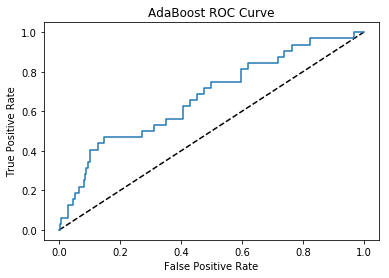

AUC: 0.6725512528473804


In [76]:
from sklearn.ensemble import AdaBoostClassifier

fit_model(AdaBoostClassifier(random_state=12), X_train_sm, y_train_sm, X_test, y_test, 'AdaBoost')

#### Parameter tuning for AdaBoost

Similar to random forest, I will now perform parameter tuning on the AdaBoost model in an attempt to optimise it's performance. 

Tuned AdaBoost Parameters: {'learning_rate': 0.5, 'n_estimators': 50} 


 AdaBoost Classification Report: 
              precision    recall  f1-score   support

          0       0.95      0.92      0.94       439
          1       0.23      0.31      0.26        32

avg / total       0.90      0.88      0.89       471



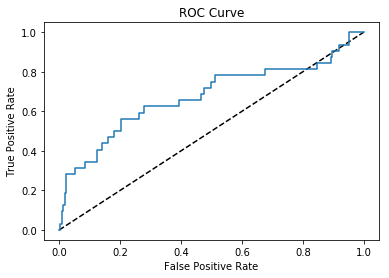

AUC: 0.6740461275626424


In [77]:
# Parameter tuning
#create classifier
ada = AdaBoostClassifier(random_state=12)

# Choose some parameter combinations to try
parameters = {'n_estimators': [5, 10, 25, 50], 
              'learning_rate': [0.01, 0.1, 0.5, 1]
             }

# Run the grid search with 10-fold cross-validation
grid = GridSearchCV(ada, parameters, scoring='roc_auc',cv=10)
grid = grid.fit(X_train_sm, y_train_sm)
print("Tuned AdaBoost Parameters: {}".format(grid.best_params_),'\n')

# Set the classifier to the best combination of parameters
ada = grid.best_estimator_

# Fit the best algorithm to the data, and print feature importances & prediction score
ada.fit(X_train_sm, y_train_sm)

ada_predictions = ada.predict(X_test)

print('\n','AdaBoost Classification Report:','\n',classification_report(y_test, ada_predictions))

# Compute predicted probabilities: y_pred_prob
ada_y_pred_prob = ada.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, ada_y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Compute and print Area Under Curve: AUC score
print("AUC: {}".format(roc_auc_score(y_test, ada_y_pred_prob)))

# save performance metrics for later comparison
accuracy_comparison['AdaBoost (tuned)'] = (accuracy_score(y_test, ada_predictions)*100).round(1)
f1_comparison['AdaBoost (tuned)'] = (f1_score(y_test, ada_predictions, average='weighted')*100).round(1)
auc_comparison['AdaBoost (tuned)'] = (roc_auc_score(y_test, ada_y_pred_prob)).round(2)

In the case of AdaBoost, the parameter tuning has not lead to any increase in performance. This suggests that the default parameters of the classifier are already close to optimum for this case.

### Comparing Models

The table below shows a comparison of model performance, ranked by the area-under-curve (AUC) value for each model's ROC curve. 

In [78]:
accuracy_df = pd.DataFrame.from_dict(accuracy_comparison, orient='index')
accuracy_df.columns = ['Accuracy']
f1_df = pd.DataFrame.from_dict(f1_comparison, orient='index')
f1_df.columns = ['F1']
auc_df = pd.DataFrame.from_dict(auc_comparison, orient='index')
auc_df.columns = ['AUC']

comparison_df = pd.merge(accuracy_df, f1_df, left_index=True, right_index=True)
comparison_df = pd.merge(comparison_df, auc_df, left_index=True, right_index=True)
comparison_df.sort_values(by=['AUC'],inplace=True,ascending=False)
display(comparison_df)

,Accuracy,F1,AUC
Random Forest (tuned),93.4,90.4,0.69
AdaBoost,89.6,89.4,0.67
AdaBoost (tuned),88.1,89.0,0.67
Random Forest,92.8,90.4,0.64
Decision Tree,85.4,86.6,0.53


As expected, both AdaBoost and Random Forest out-perform the Decision Tree model here. The performance is still not optimum however, and has a lot of room for improvement. I will now attempt to improve both models by using PCA (principle component analysis) to select a smaller number of features for use in the models.

### Reducing Dimensionality using PCA

#### Standardise all features (neccessary for PCA)

In [79]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_train)

# Apply to both the training set and the test set
X_train_pca = scaler.transform(X_train)
X_test_pca = scaler.transform(X_test)

Perform PCA, retaining 95% of the variance in the dataset (retaining less variance, means less features).

In [80]:
from sklearn.decomposition import PCA

# Create instance of the model and fit to training data
pca = PCA(.95)

pca.fit(X_train_pca)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In this case, 95% of the variance being retained amounts to 158 principal components being chosen by PCA. This means that we will only have 158 features, once the model is applied.

In [81]:
pca.n_components_ 

158

In [82]:
# currently have 442 features

print(X_train_pca.shape)
print(X_test_pca.shape)

(1096, 442)
(471, 442)


Apply the model to both the training and test sets.

In [83]:
X_train_pca = pca.transform(X_train_pca)
X_test_pca = pca.transform(X_test_pca)

In [84]:
# we now have a reduced 158 features

print(X_train_pca.shape)
print(X_test_pca.shape)

(1096, 158)
(471, 158)


### Modelling after PCA with AdaBoost

Here I will re-apply both AdaBoost and Random Forest. I will also experiment with a second resampling technique, random oversampling, in an attempt to improve performance.

#### Re-sampling Method 1: SMOTE

In [85]:
# perform SMOTE resampling on PCA dataset with reduced features

sm = SMOTE(random_state=11, ratio = 'auto')
X_train_sm, y_train_sm = sm.fit_sample(X_train_pca, y_train)

In [86]:
print("Percentage of positive samples in training set before re-sampling","\n",(y_train.sum())/(y_train.count())*100)

print("Percentage of positive samples in training set after re-sampling","\n",(y_train_sm.sum())/len(y_train_sm)*100)

Percentage of positive samples in training set before re-sampling 
 6.569343065693431
Percentage of positive samples in training set after re-sampling 
 50.0


**AdaBoost Model (with SMOTE and PCA)**

AdaBoost CV Scores on Training Data: [0.81067961 0.88349515 0.90291262 0.89805825 0.96078431 0.92156863
 0.91176471 0.89705882 0.91176471 0.93137255]

 Mean of Accuracy on Training Data: 0.9029459356558158

 Accuracy Score on Test Data: 0.8259023354564756

 AdaBoost Classification Report: 
              precision    recall  f1-score   support

          0       0.93      0.88      0.90       439
          1       0.05      0.09      0.07        32

avg / total       0.87      0.83      0.85       471



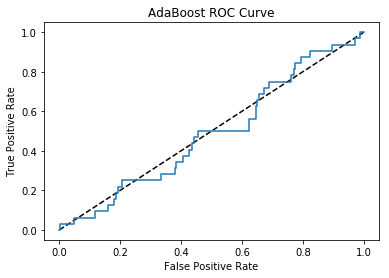

AUC: 0.48953587699316636


In [87]:
fit_model(AdaBoostClassifier(random_state=12), X_train_sm, y_train_sm, X_test_pca, y_test, 'AdaBoost')

It is clear here that the use of PCA has drastically reduced the effectiveness of the AdaBoost algorithm on our dataset.

**Random Forest Model (with SMOTE and PCA)**

Random Forest CV Scores on Training Data: [0.94660194 0.98058252 0.94174757 0.96116505 0.99019608 0.98039216
 0.96568627 0.96568627 0.96078431 0.9754902 ]

 Mean of Accuracy on Training Data: 0.9668332381496286

 Accuracy Score on Test Data: 0.9256900212314225

 Random Forest Classification Report: 
              precision    recall  f1-score   support

          0       0.93      0.99      0.96       439
          1       0.20      0.03      0.05        32

avg / total       0.88      0.93      0.90       471



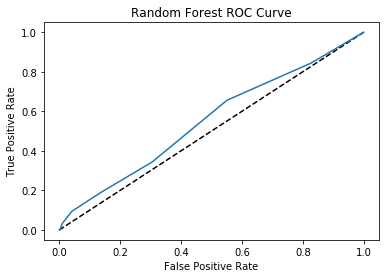

AUC: 0.5499359339407744


In [88]:
fit_model(RandomForestClassifier(random_state=12), X_train_sm, y_train_sm, X_test_pca, y_test, 'Random Forest')

The performance of Random Forest has also suffered. This suggest that there has been significant loss of information when performing PCA.

#### Re-sampling Method 2: Random Over-sampling (ROS)

In [89]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_sample(X_train_pca, y_train)

In [90]:
print("Percentage of positive samples in training set before re-sampling","\n",(y_train.sum())/(y_train.count())*100)

print("Percentage of positive samples in training set after re-sampling","\n",(y_train_ros.sum())/len(y_train_ros)*100)

Percentage of positive samples in training set before re-sampling 
 6.569343065693431
Percentage of positive samples in training set after re-sampling 
 50.0


**AdaBoost Model (with ROS and PCA) **

AdaBoost CV Scores on Training Data: [0.91747573 0.94174757 0.93203883 0.96601942 0.92156863 0.95098039
 0.94607843 0.91666667 0.95588235 0.9754902 ]

 Mean of Accuracy on Training Data: 0.9423948220064723

 Accuracy Score on Test Data: 0.8067940552016986

 AdaBoost Classification Report: 
              precision    recall  f1-score   support

          0       0.94      0.85      0.89       439
          1       0.11      0.25      0.15        32

avg / total       0.88      0.81      0.84       471



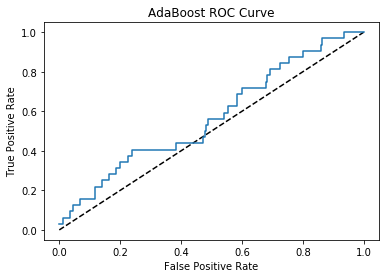

AUC: 0.5713980637813212


In [91]:
fit_model(AdaBoostClassifier(random_state=12), X_train_ros, y_train_ros, X_test_pca, y_test, 'AdaBoost')

**Random Forest Model (with ROS and PCA)**

Random Forest CV Scores on Training Data: [1.         1.         1.         1.         1.         1.
 0.99509804 1.         1.         1.        ]

 Mean of Accuracy on Training Data: 0.9995098039215687

 Accuracy Score on Test Data: 0.9320594479830149

 Random Forest Classification Report: 
              precision    recall  f1-score   support

          0       0.93      1.00      0.96       439
          1       0.00      0.00      0.00        32

avg / total       0.87      0.93      0.90       471



/Users/Max/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


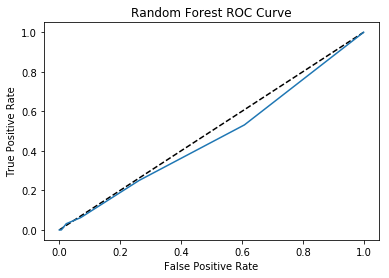

AUC: 0.46761104783599095


/Users/Max/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [92]:
fit_model(RandomForestClassifier(random_state=12), X_train_ros, y_train_ros, X_test_pca, y_test, 'Random Forest')

It can be seen above that the performance of both models (particularly Random Forest) has suffered as a result of using a combination of ROS and PCA.

### Conclusion

**Best Performing Model**

The best performing model was Random Forest with a combination of SMOTE resampling, and without the use of any PCA. 

In all cases, the use of PCA to reduce dimensionality actually worsened performance, and oversampling proved an unsuitable method for dealing with the class imbalance in this dataset. In order to improve the model, I believe that a more in-depth EDA of the data could have a positive effect, as it would result in better feature selection.  